# [Hands-On] Understanding Reinforcement Learning and Implementation (Numeric Data Version)

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

# Overview
This lecture focuses on implementing Deep Q-Network (DQN) for the CartPole environment, one of the classic problems in reinforcement learning. You'll learn how to build a DQN from scratch and understand its core components.

# What is CartPole?
CartPole is a classic control problem where an agent needs to balance a pole on a moving cart. The objective is to keep the pole upright by moving the cart left or right. It's an excellent environment for learning RL concepts because:

- Simple to understand but challenging to master
- Low-dimensional state space (4 dimensions)
- Binary action space (left or right)
- Clear success criteria

# What We'll Build
In this tutorial, we'll implement:

1. State management system for temporal context
2. Neural network architecture for Q-learning
3. Experience replay mechanism
4. Complete DQN training loop
5. Visualization tools for analysis

# Environment Setup
First, let's install the required packages:

In [105]:
!pip install gymnasium pygame
!pip install imageio matplotlib pillow

# Required Libraries
Let's import all necessary libraries for our implementation:

In [106]:
import gymnasium as gym
import os
import numpy as np
import imageio
from PIL import Image, ImageDraw, ImageFont
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

import matplotlib.pyplot as plt
from IPython.display import Image as IPyImage
from IPython.display import display, HTML
%matplotlib inline


## Key libraries we're using:

- gymnasium: For the CartPole environment
- torch: For neural network implementation
- imageio: For creating visual outputs
- matplotlib: For plotting results

# State Management
## StateStorage Class
One key innovation in our implementation is stacking multiple states to provide temporal context to our agent. Here's how we manage state history:

In [107]:
class StateStorage:
    """
    Stores the most recent n states and returns them as a stacked tensor.
    Example: If n=4, always provides states in the form [s(t-3), s(t-2), s(t-1), s(t)]
    """
    def __init__(self, state_dim, stack_size=4):
        """
        Args:
            state_dim (int): Dimension of a single state (4 for CartPole)
            stack_size (int): Number of recent states to stack
        """
        self.stack_size = stack_size
        self.state_dim = state_dim
        
        # Deque to store states
        # Maximum length = stack_size
        self.storage = deque(maxlen=stack_size)
        
        # Initialize by pre-filling with zero vectors
        for _ in range(stack_size):
            self.storage.append(np.zeros(state_dim, dtype=np.float32))

    def push(self, state):
        """
        Store a new single state. The oldest state is automatically removed (deque)
        """
        self.storage.append(state)

    def get_stacked_state(self):
        """
        Combines all currently stacked states and returns them in shape (stack_size * state_dim,)
        (or in 2D form: [stack_size, state_dim])
        """
        # Example: stack_size=4, state_dim=4 -> shape=(4,4)
        stacked = np.array(self.storage, dtype=np.float32)
        # Here's an example of flattening to (stack_size * state_dim)
        stacked = stacked.reshape(-1)  # shape: (4*4,) = (16,)
        return stacked

   - We keep the last few observations (e.g., 4 in a row) so the agent can see how the state is changing over time.  
   - This helps the agent implicitly understand velocity and momentum without needing more complex inputs.

# Neural Network Architecture
## Numeric Encoder
The encoder transforms our state vectors into a higher-dimensional representation:

In [108]:
class NumericEncoder(nn.Module):
    """
    Transforms numeric state (e.g., CartPole 16 dimensions) to latent embedding (e.g., 128 dimensions)
    """
    def __init__(self, input_dim, embed_dim=128):
        super(NumericEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim),
            nn.ReLU()
        )

    def forward(self, x):
        """
        x: (batch_size, input_dim) numeric data
        return: (batch_size, embed_dim)
        """
        return self.fc(x)

Design choices:

- Two-layer MLP architecture
- ReLU activation for non-linearity
- Customizable embedding dimension

## DQN Network
Our complete DQN combines the encoder with a policy head:

### PolicyNetwork (DQN)

In [109]:
class DQN(nn.Module):
   """
   Network combining Encoder + Policy Head
   - Encoder: NumericEncoder 
   - Policy Head: FC layer -> Outputs Q-value for each action
   """
   def __init__(self, input_dim, action_dim, embed_dim=128):
       super(DQN, self).__init__()
       self.encoder = NumericEncoder(input_dim, embed_dim)
       self.q_head = nn.Linear(embed_dim, action_dim)

   def forward(self, x):
       """
       x: (batch_size, input_dim)
       return: (batch_size, action_dim)  # Q-value for each action 
       """
       emb = self.encoder(x)
       q = self.q_head(emb)
       return q

We use a simple multi-layer perceptron (MLP) to map our stacked state (e.g., 16 numbers when 4 observations × 4 state features) into Q-values for each action.  
The network outputs the predicted value of taking each possible action in the current state.

- Encoder: State → Latent embedding
- Policy head: Latent → Q-values
- Output: Q-value for each possible action

# Experience Management

## Replay Buffer
The replay buffer is crucial for stable learning in DQN:

In [110]:
class ReplayBuffer:
   """
   Experience replay buffer for DQN
   Stores (s, a, r, s_next, done) tuples and samples them in batches.
   """
   def __init__(self, capacity=10000):
       self.buffer = deque(maxlen=capacity)
   
   def push(self, state, action, reward, next_state, done):
       self.buffer.append((state, action, reward, next_state, done))

   def sample(self, batch_size):
       batch = random.sample(self.buffer, batch_size)
       states, actions, rewards, next_states, dones = zip(*batch)
       return np.array(states), actions, rewards, np.array(next_states), dones

   def __len__(self):
       return len(self.buffer)

   - Instead of training on consecutive states (which could be highly correlated), we store experiences in a replay buffer.  
   - Each experience is a tuple of (state, action, reward, next_state, done).  
   - We randomly sample mini-batches from this buffer for training, which helps stabilize learning.

# Training Loop

The store_frames_and_info function is a crucial component of our visualization system, designed to capture and store both visual and textual information during the training process. This function creates a comprehensive record of the agent's behavior and performance that can be analyzed later.

In [111]:
def store_frames_and_info(episode_number, frames, info_texts, render_path):
   """
   Args:
       episode_number (int): Episode number
       frames (list of np.array): Array of rendered images
       info_texts (list of str): Information (string) for each step
       render_path (str): Path to parent folder for saving
   """
   ep_folder = os.path.join(render_path, f"episode_{episode_number}")
   os.makedirs(ep_folder, exist_ok=True)

   for i, (img, info_str) in enumerate(zip(frames, info_texts)):
       # step_xxx.png
       png_path = os.path.join(ep_folder, f"step_{i:03d}.png")
       imageio.imwrite(png_path, img)
       
       # step_xxx.info.txt
       info_path = os.path.join(ep_folder, f"step_{i:03d}.info.txt")
       with open(info_path, "w", encoding="utf-8") as f:
           f.write(info_str)

   - **Epsilon-greedy strategy**: With probability \(\epsilon\), select a random action (exploration). Otherwise, pick the action with the highest Q-value (exploitation).  
   - **Target Network**: We use two networks (main and target). The target network is updated every so often to stabilize learning.  
   - **Loss Function**: MSE (mean squared error) between predicted Q-values and target Q-values (calculated using rewards + discounted future value).

In [112]:
def train_dqn(
    env_name="CartPole-v1",
    num_episodes=100,
    stack_size=4,
    batch_size=32,
    gamma=0.99,
    lr=1e-3,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=500,
    target_update_interval=20,
    buffer_capacity=50000,
    save_render=True,
    render_path="./cartpole_frames"
):
    """
    DQN training function
      - Saves images (.png) and info (.info.txt) every episode where (episode+1) % 10 == 0
    """
    if save_render and not os.path.exists(render_path):
        os.makedirs(render_path)

    env = gym.make(env_name, render_mode="rgb_array")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    input_dim = state_dim * stack_size
    dqn = DQN(input_dim, action_dim, embed_dim=128)
    target_dqn = DQN(input_dim, action_dim, embed_dim=128)
    target_dqn.load_state_dict(dqn.state_dict())

    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=buffer_capacity)

    # Epsilon
    epsilon = epsilon_start
    epsilon_decay_rate = (epsilon_start - epsilon_end) / epsilon_decay

    total_rewards_list = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state_storage = StateStorage(state_dim, stack_size)
        for _ in range(stack_size):
            state_storage.push(obs)

        done = False
        episode_reward = 0

        # Temporary lists for rendering and text storage
        episode_frames = []
        episode_info_texts = []

        step_count = 0

        while not done:
            # Current stacked state
            stacked_state = state_storage.get_stacked_state()

            # \(\epsilon\)-greedy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_t = torch.FloatTensor(stacked_state).unsqueeze(0)
                    q_values = dqn(state_t)
                    action = q_values.argmax(dim=1).item()

            # Perform step
            next_obs, reward, done, truncated, info = env.step(action)
            done = done or truncated
            state_storage.push(next_obs)
            next_stacked_state = state_storage.get_stacked_state()

            # Store in buffer
            replay_buffer.push(stacked_state, action, reward, next_stacked_state, done)

            episode_reward += reward

            # ==== Rendering and info collection ====
            if save_render:
                frame = env.render()  # (H, W, 3) numpy
                episode_frames.append(frame)
                
                # CartPole state (obs[0] = pos, obs[1] = vel, obs[2] = angle, obs[3] = angular vel)
                # Can record based on either next_obs or obs for convenience
                info_str = (
                    f"Episode={episode+1}, Step={step_count}\n"
                    f"Cart Position={obs[0]:.3f}, Cart Velocity={obs[1]:.3f}\n"
                    f"Pole Angle={obs[2]:.3f}, Pole Angular Vel={obs[3]:.3f}\n"
                    f"Action={action}, Reward={reward:.2f}\n"
                )
                episode_info_texts.append(info_str)
            # ============================

            obs = next_obs
            step_count += 1

            # Training
            if len(replay_buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                states_t = torch.FloatTensor(states)
                actions_t = torch.LongTensor(actions).unsqueeze(1)
                rewards_t = torch.FloatTensor(rewards).unsqueeze(1)
                next_states_t = torch.FloatTensor(next_states)
                dones_t = torch.BoolTensor(dones).unsqueeze(1)

                # Q(s,a)
                q_pred = dqn(states_t).gather(1, actions_t)
                
                with torch.no_grad():
                    q_next = target_dqn(next_states_t).max(dim=1, keepdim=True)[0]
                    q_target = rewards_t + gamma * q_next * (~dones_t)

                loss = F.mse_loss(q_pred, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Decrease epsilon
                if epsilon > epsilon_end:
                    epsilon -= epsilon_decay_rate

        total_rewards_list.append(episode_reward)

        # Update target network
        if (episode+1) % target_update_interval == 0:
            target_dqn.load_state_dict(dqn.state_dict())

        # Log every 10 episodes
        if (episode+1) % 5 == 0:
            avg_reward = np.mean(total_rewards_list[-10:])
            print(f"[Episode {episode+1}] \t Avg Reward (last 10 ep): {avg_reward:.2f}, \t Epsilon={epsilon:.3f}")

            # Save frames & info
            if save_render:
                store_frames_and_info(
                    episode_number=episode+1,
                    frames=episode_frames,
                    info_texts=episode_info_texts,
                    render_path=render_path
                )

    env.close()
    return dqn, total_rewards_list

# Visualization Tools

We've implemented comprehensive visualization tools:

- Frame capture during training
- State information overlay
- GIF creation for episode replay

During each episode, we can save frames and text info to see what happens in each step (such as cart position, pole angle, and chosen action).  
We also provide functions to overlay this info onto images and create GIFs, making it easy to visualize the agent’s performance.

In [113]:
def overlay_text_on_image(image_path, info_path, font_path=None):
   """
   image_path: Path to PNG file
   info_path: Path to corresponding .info.txt file
   font_path: Path to TTF font (optional) 
   return: Pillow Image object (image with overlaid text)
   """
   img = Image.open(image_path).convert("RGB")
   draw = ImageDraw.Draw(img)

   # Font setup (use default if not provided)
   if font_path is not None:
       font = ImageFont.truetype(font_path, size=18)
   else:
       font = ImageFont.load_default()

   text = ""
   if os.path.exists(info_path):
       with open(info_path, "r", encoding="utf-8") as f:
           text = f.read()

   # Display multi-line text with line breaks
   lines = text.strip().split("\n")

   # Position setup
   x, y = 10, 10
   padding = 5  # Padding for black box
   max_width = max([draw.textlength(line, font=font) for line in lines]) + 2 * padding
   box_height = len(lines) * 20 + 2 * padding  # Adjust box size based on number of lines

   # Semi-transparent black box (improves readability)
   draw.rectangle([(x - padding, y - padding), (x + max_width, y + box_height)], fill=(0, 0, 0, 150))

   # Add text (yellow)
   for line in lines:
       draw.text((x, y), line, fill=(255, 255, 0), font=font)
       y += 20  # Line spacing

   return img

In [114]:
def make_gif_with_overlay(ep_folder, output_gif="cartpole_overlay.gif", fps=30, font_path=None):
   """
   ep_folder: 'episode_N' path (folder containing PNG & info.txt files)
   output_gif: Path for the output GIF file
   font_path: Path to TTF font to use (uses default font if not provided)
   """
   # Sort PNG files (step_000.png, step_001.png ...)
   file_list = sorted([f for f in os.listdir(ep_folder) if f.endswith(".png")])
   frames = []

   for file_name in file_list:
       image_path = os.path.join(ep_folder, file_name)
       info_path = image_path.replace(".png", ".info.txt")
       # Create image with text overlay
       annotated_img = overlay_text_on_image(image_path, info_path, font_path=font_path)
       frames.append(np.array(annotated_img))  # Convert to numpy array

   if len(frames) > 0:
       imageio.mimsave(output_gif, frames, fps=fps)
       print(f"GIF saved: {output_gif}")
   else:
       print(f"No PNG files found in {ep_folder}.")

#### Running the Training
To train your agent:

In [115]:
dqn_model, rewards = train_dqn(
    env_name="CartPole-v1",
    num_episodes=500,
    save_render=True,
    render_path="./cartpole_frames"
)

[Episode 5] 	 Avg Reward (last 10 ep): 19.60, 	 Epsilon=0.869
[Episode 10] 	 Avg Reward (last 10 ep): 17.50, 	 Epsilon=0.717
[Episode 15] 	 Avg Reward (last 10 ep): 15.00, 	 Epsilon=0.572
[Episode 20] 	 Avg Reward (last 10 ep): 15.40, 	 Epsilon=0.412
[Episode 25] 	 Avg Reward (last 10 ep): 16.40, 	 Epsilon=0.248
[Episode 30] 	 Avg Reward (last 10 ep): 13.60, 	 Epsilon=0.143
[Episode 35] 	 Avg Reward (last 10 ep): 13.50, 	 Epsilon=0.008
[Episode 40] 	 Avg Reward (last 10 ep): 12.60, 	 Epsilon=0.008
[Episode 45] 	 Avg Reward (last 10 ep): 12.90, 	 Epsilon=0.008
[Episode 50] 	 Avg Reward (last 10 ep): 18.70, 	 Epsilon=0.008
[Episode 55] 	 Avg Reward (last 10 ep): 15.20, 	 Epsilon=0.008
[Episode 60] 	 Avg Reward (last 10 ep): 15.50, 	 Epsilon=0.008
[Episode 65] 	 Avg Reward (last 10 ep): 20.60, 	 Epsilon=0.008
[Episode 70] 	 Avg Reward (last 10 ep): 23.60, 	 Epsilon=0.008
[Episode 75] 	 Avg Reward (last 10 ep): 23.70, 	 Epsilon=0.008
[Episode 80] 	 Avg Reward (last 10 ep): 26.50, 	 Epsilon

In [118]:
ep_folder = "./cartpole_frames/episode_500"
make_gif_with_overlay(ep_folder, output_gif="cartpole_ep500.gif", fps=30)

GIF saved: cartpole_ep500.gif


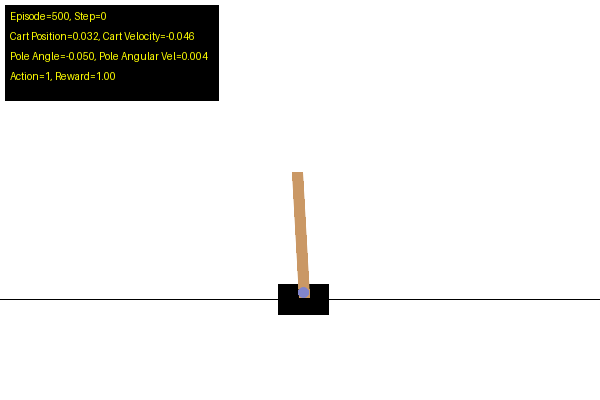

In [120]:
# Display saved GIF file in Jupyter Notebook
IPyImage(filename="cartpole_ep500.gif")

# Conclusion
- **DQN** is a straightforward approach to map states → Q-values with a neural network.  
- **Experience Replay** helps break correlation in training samples.  
- **Target Network** provides more stable training by decoupling the updates.  
- **State Stacking** is a simple trick to give the agent short-term memory without using recurrent networks.

By following these steps, you can train an agent that balances the pole for longer and longer episodes. Over time, the agent learns to keep the pole upright more consistently, demonstrating the power of RL even with a relatively simple neural network.